In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import csv
import ipdb
import sys
import numpy as np
import base64
import os
import random
import numpy as np
import json
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.image as mpimg

In [2]:
class network(nn.Module):
    def __init__(self,input_nodes,hidden_nodes,output_nodes):
        super(network, self).__init__()
        self.fc1= nn.Linear(input_nodes,hidden_nodes)
        nn.init.xavier_uniform_(self.fc1.weight)
        self.bn1 = nn.BatchNorm1d(num_features=hidden_nodes)
        
        self.fc2= nn.Linear(hidden_nodes,hidden_nodes)
        nn.init.xavier_uniform_(self.fc2.weight)
        self.bn2 = nn.BatchNorm1d(num_features=hidden_nodes)
        
        self.fc3=nn.Linear(hidden_nodes,output_nodes)
        nn.init.xavier_uniform_(self.fc3.weight)      
        
    def forward(self,X):
        X = torch.tanh(self.bn1(self.fc1(X)))
        X = self.fc2(X)
        X = F.dropout2d(X,p=0.5)
        X = torch.tanh(X)
        out = self.fc3(X)
        return out  

In [3]:
def getdataloaders(data, batch_size = 50):
    
    np.random.shuffle(data)
    batches=[]
    
    data[:,4:6]-=data[:,4:6].mean(0)
    data[:,4:6]/=data[:,4:6].var(0)
    
    train_data1=data[:15000,:]
    test_data1=data[15000:,:]

    #creating train batches
    train_batch_number = int(train_data1.shape[0]/batch_size)
    train_data = train_data1[0:batch_size,:]
    
    for idx in range(1,train_batch_number):
        data = train_data1[idx*batch_size:(idx + 1)*batch_size,:]
        train_data=np.dstack((train_data,data))
        
    train_data = np.transpose(train_data, (2, 0, 1))
    
    #creating test batches
    test_batch_number = int(test_data1.shape[0]/batch_size)
    test_data = test_data1[0:batch_size,:]
    
    for idx in range(1,test_batch_number):
        data = test_data1[idx*batch_size:(idx + 1)*batch_size,:]
        test_data=np.dstack((test_data,data))
        
    test_data = np.transpose(test_data, (2, 0, 1))
    
    return train_data, test_data

In [4]:
def train(trainloader, optimizer, criterion, epoch, net, scope = 'cl'):
    
    net.train()
    train_loss_sum = 0
    for idx in range(trainloader.size(0)):
        if scope == 'cl':
            target = trainloader[idx,:,6].reshape(trainloader.size(1),1)
        if scope == 'cd':
            target = trainloader[idx,:,7].reshape(trainloader.size(1),1)
        digits = trainloader[idx,:,:4]
        
        #creating one hot vector
        one_hot_vectors = torch.zeros([42,trainloader.size(1)])
        for ndx,row in enumerate(digits):
            row = row.reshape(row.size(0),1)
            row = row.long()
            num_classes = 10
            one_hot_digits = (row == torch.arange(num_classes).reshape(1, num_classes)).float()
            one_hot_digits = one_hot_digits.reshape(-1,1)
            #trainloader[idx,ndx,4:6]-=trainloader[idx,ndx,4:6].mean(0)
            #trainloader[idx,ndx,4:6]/=trainloader[idx,ndx,4:6].var(0)
            one_hot_vector = torch.cat((one_hot_digits,trainloader[idx,ndx,4:6].reshape(2,1).float()),0)
            one_hot_vector = one_hot_vector.reshape(one_hot_vector.size(),1)
            one_hot_vectors[:,ndx] = one_hot_vector[:,0]
            
        one_hot_vectors = torch.t(one_hot_vectors)
        
        output = net.forward(one_hot_vectors)
        loss = criterion(output,target.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 
        train_loss_sum += float(loss)
    train_loss = train_loss_sum/trainloader.size(0)
    return train_loss
        
def test(testloader, criterion, epoch, net, scope = 'cl'):
    net.eval()
    test_loss_sum = 0
    for idx in range(testloader.size(0)):
        if scope == 'cl':
            target = testloader[idx,:,6].reshape(testloader.size(1),1)
        if scope == 'cd':
            target = testloader[idx,:,7].reshape(testloader.size(1),1)
        digits = testloader[idx,:,:4]
        if idx == 7 and epoch == 29:
            print('original',testloader[7,2,:])

        #creating one hot vector
        one_hot_vectors = torch.zeros([42,testloader.size(1)])
        for ndx,row in enumerate(digits):
            row = row.reshape(row.size(0),1)
            row = row.long()
            num_classes = 10
            one_hot_digits = (row == torch.arange(num_classes).reshape(1, num_classes)).float()
            one_hot_digits = one_hot_digits.reshape(-1,1)
            #testloader[idx,ndx,4:6]-=testloader[idx,ndx,4:6].mean(0)
            #testloader[idx,ndx,4:6]/=testloader[idx,ndx,4:6].var(0)
            one_hot_vector = torch.cat((one_hot_digits,testloader[idx,ndx,4:6].reshape(2,1).float()),0)
            one_hot_vector = one_hot_vector.reshape(one_hot_vector.size(),1)
            one_hot_vectors[:,ndx] = one_hot_vector[:,0]

        one_hot_vectors = torch.t(one_hot_vectors)
        output = net.forward(one_hot_vectors)
        if idx == 7 and epoch == 29:
            print(output[2])
        loss = criterion(output,target.float())
        test_loss_sum += float(loss)
    test_loss = test_loss_sum/testloader.size(0)
    return test_loss   

In [5]:
def plot_loss(x,y):
    plt.plot(x,y)
    plt.show()

original tensor([ 4.0000,  4.0000,  1.0000,  2.0000, -0.0000,  0.0071,  0.6340,  0.0122],
       dtype=torch.float64)
tensor([0.7804], grad_fn=<SelectBackward>)


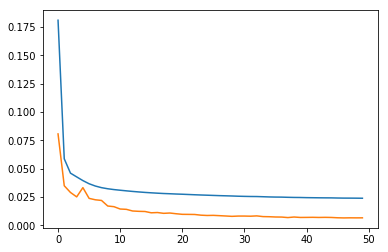

In [6]:
input_nodes = 42
hidden_nodes = 60
output_nodes = 1
batch_number = 50
learning_rate = 0.005
epochs = 50

#loading the data
data=np.load("data_float.npy")
train_data,test_data = getdataloaders(data, batch_number)
trainloader = torch.from_numpy(train_data)
testloader = torch.from_numpy(test_data)

#creating the network and defining loss function
cl_net = network(input_nodes,hidden_nodes,output_nodes)
optimizer = torch.optim.Adam(cl_net.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

#training the network\
train_loss_list = []
test_loss_list = []
epoch_list = []
for epoch in range(epochs):
    train_loss=train(trainloader, optimizer, criterion, epoch, cl_net, scope = 'cl')
    test_loss= test(testloader, criterion, epoch, cl_net, scope = 'cl')
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    epoch_list.append(epoch)

#plotting the losses
plt.plot(epoch_list,train_loss_list)
plt.plot(epoch_list,test_loss_list)

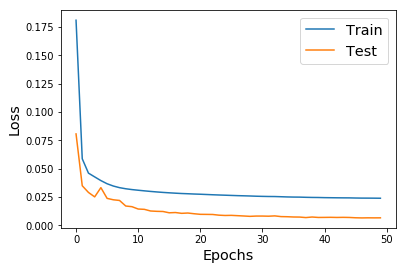

In [10]:
#plotting the losses
plt.plot(epoch_list,train_loss_list,label = 'Train')
plt.plot(epoch_list,test_loss_list,label = 'Test')
plt.xlabel("Epochs",fontsize='x-large')
plt.ylabel("Loss",fontsize='x-large')
plt.legend(fontsize='x-large')